## Table of Contents

1. [Problem Statement](#1.-Problem-Statement)
2. [Data](#2.-Data:-Google-Local-Data-(2021))
3. [EDA & Data Preprocessing](#3.-EDA-&-Data-Preprocessing)
4. [Modeling Approach](#4.-Modeling-Approach)
    - [4.1 Baseline Model](#4.1-Baseline-Model)
    - [4.2 Incorporating Review Embeddings (Text-based)](#4.2-Incorporating-Review-Embeddings-(Text-based))
        - [4.2.1 Word2Vec](#4.2.1-Word2Vec)
        - [4.2.2 Bag of Words](#4.2.2-Bag-of-Words)
        - [4.2.3 Latent Dirichlet Allocation (LDA)](#4.2.3-Latent-Dirichlet-Allocation-(LDA))
        - [4.2.4 Large Language Model (BERT)](#4.2.4-Large-Language-Model-(BERT))
5. [Results](#5.-Results)

---


# 1. Problem Statement

# 2. Data: Google Local Data (2021)

**Citation**

**UCTopic: Unsupervised Contrastive Learning for Phrase Representations and Topic Mining**  
Jiacheng Li, Jingbo Shang, Julian McAuley  
*Annual Meeting of the Association for Computational Linguistics (ACL)*, 2022  
[pdf](https://aclanthology.org/2022.acl-long.426.pdf)


**Personalized Showcases: Generating Multi-Modal Explanations for Recommendations**  
An Yan, Zhankui He, Jiacheng Li, Tianyang Zhang, Julian Mcauley  
*The 46th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR)*, 2023  
[pdf](https://arxiv.org/pdf/2207.00422.pdf)

**Data Source**

The Google Local Dataset offers a comprehensive collection from Google Local (Google Maps), featuring 65,000 restaurants and over 1.77 million reviews, along with 4.43 million images posted by approximately 1.01 million users. It contains detailed information such as geographical location, business category,
opening status, price levels, and average ratings for each restaurant. This multi-modal dataset
includes textual reviews, user-generated images, and various metadata attributes, providing a
comprehensive foundation for analyzing consumer preferences and behaviors in the context of
restaurant recommendations.

For our project, we decided to focus on the resturants in Massachusetts, which includes 5,624,944 reviews and 92,520 businesses in metadata.

*Massachusetts 10-cores Review Dataset*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

*Masechusetts Metadata*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

# 3. EDA & Data Preprocessing 

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from utility import is_english, get_emoji_pattern, merge_df

RERUN_PREPROCESSING = False

In [2]:
review_ma = pd.read_json('data/review-Massachusetts_10.json', lines=True)
metadata_ma = pd.read_json('data/meta-Massachusetts.json', lines=True)

# Filter out restaurants based on business category
restaurant_ma = metadata_ma[metadata_ma['category'].apply(lambda x: 'Restaurant' in x if isinstance(x, list) else False)]

# Drop duplicated rows
review_ma = review_ma.drop_duplicates(subset=['user_id', 'name', 'time', 'rating', 'text', 'gmap_id'])
restaurant_ma = restaurant_ma.drop_duplicates(subset = ["name", "address", "gmap_id", "url"])

df = pd.merge(review_ma, restaurant_ma, on='gmap_id', how='inner')
df.to_csv("data/data_ma.csv", index=False)

In [3]:
df = pd.read_csv("data/data_ma.csv")
print("Number of restaurant reviews in MA:", len(df))

/var/folders/wh/3zjhqx7s7d747p205gcyh2480000gn/T/ipykernel_29930/277753387.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


Number of restaurant reviews in MA: 1239217


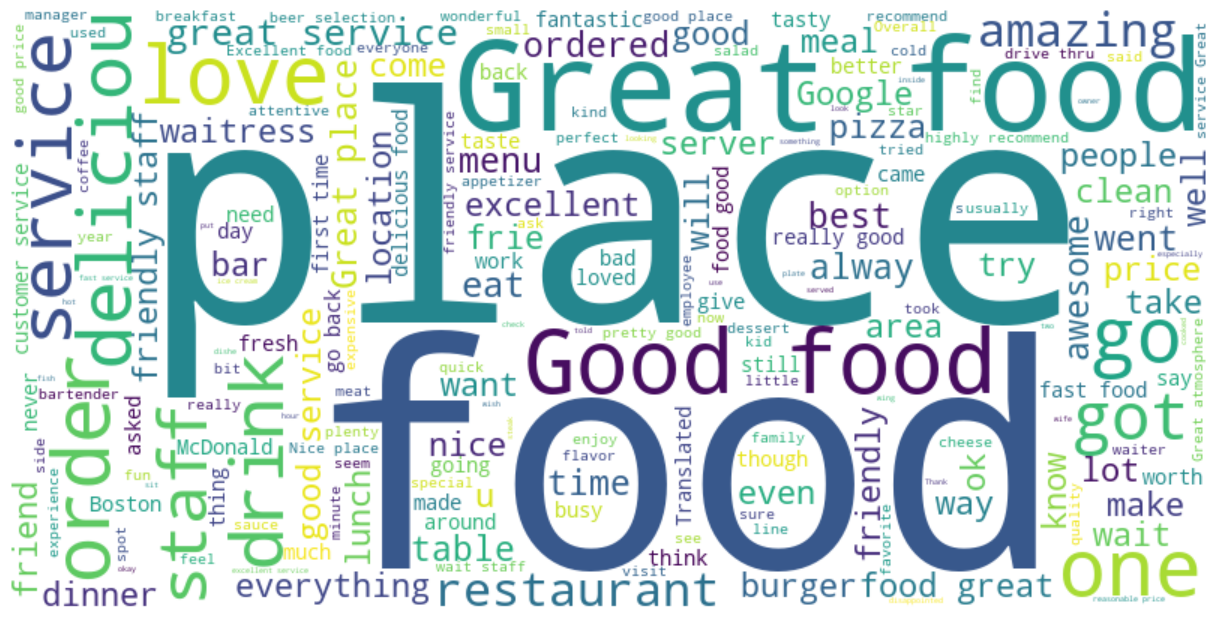

In [4]:
if RERUN_PREPROCESSING:
    all_text = df[-df['text'].isna()].drop_duplicates(subset='text', keep='first').text.to_list()
    
    with open('data/reviews.json', 'w', encoding='utf-8') as file:
        json.dump(all_text, file, ensure_ascii=False, indent=2)

all_text = pd.read_json('data/reviews.json').iloc[:,0].tolist()

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(all_text))
plt.figure(figsize = (12, 6), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

The Word Cloud highlights the following key themes:
1. **Emphasis on Food Quality and Experience:** The largest words, like "good," "food," and "great," indicate that these are the most common descriptors used in reviews. This suggests that the overall quality of food and the dining experience are central to customer feedback.
2. **Service Quality:** The prominence of words such as "service" and "staff" alongside positive terms like "amazing," "excellent," and "friendly" suggests that service quality is a significant factor in customer satisfaction.
3. **Specific Offerings and Descriptors:** The presence of specific food items or attributes, such as "pizza," "burger," "lunch," and "breakfast," shows that customers often comment on particular dishes or meals, indicating standout items or specialties that may draw in patrons.
4. **Emotional Connections:** The use of words like "love" and "favorite" reflects strong emotional connections and personal preferences.



### Keep only English reviews

In [5]:
if RERUN_PREPROCESSING:    
    df_filtered = df[-df['text'].isna()].drop_duplicates(
            subset='text', 
            keep='first'
            # The reviews match data/reviews.json
        )[['user_id', 'gmap_id', 'text', 'rating']]

    english_mask = df['text'].apply(is_english)

    df_filtered = df_filtered[english_mask]
    df_filtered.to_csv("data/english_reviews.csv", index=False)

### Remove emoji

In [6]:
df_filtered = pd.read_csv("data/english_reviews.csv")

emoji_pattern = get_emoji_pattern()

has_emoji = df_filtered.text.apply(lambda x: bool(emoji_pattern.search(x)))
print('#Reviews containing emoji:', df_filtered[has_emoji].text.count())

df_filtered['text'] = df_filtered['text'].apply(lambda x: emoji_pattern.sub(r'', x))

#Reviews containing emoji: 15685


### Reduce to extract the k-core for text

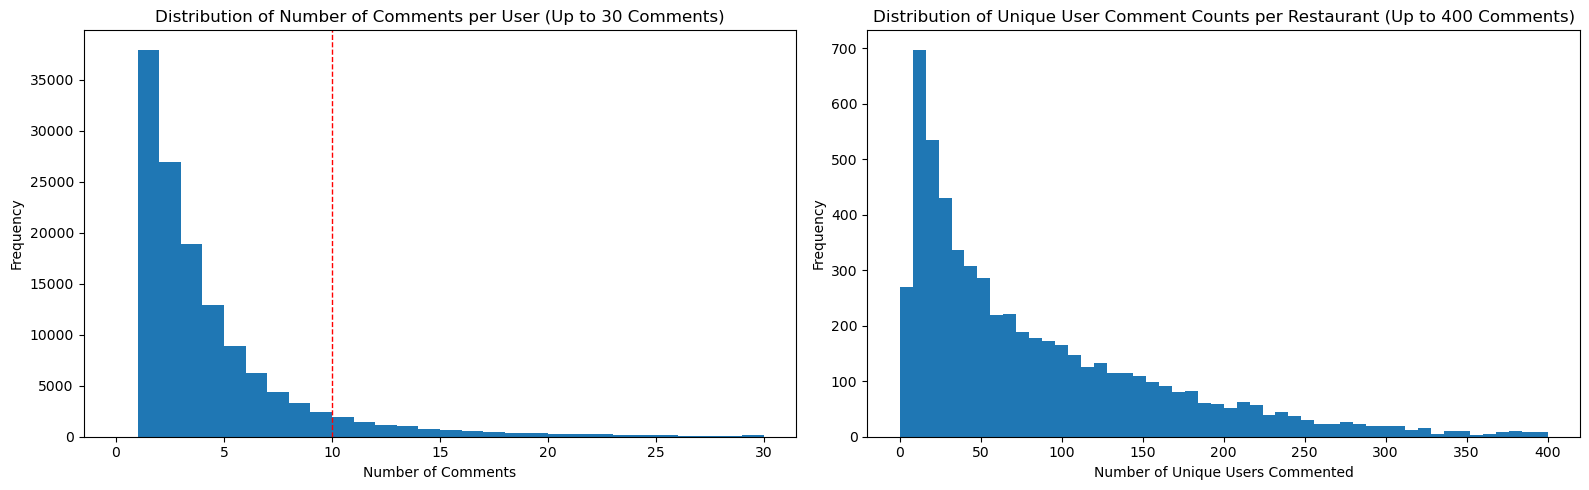

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

comment_counts = df_filtered['user_id'].value_counts()
threshold = 30
axes[0].hist(comment_counts[comment_counts <= threshold], bins=threshold, range=(0, threshold))
axes[0].axvline(x=10, color='r', linestyle='--', linewidth=1)
axes[0].set_title(f'Distribution of Number of Comments per User (Up to {threshold} Comments)')
axes[0].set_xlabel('Number of Comments')
axes[0].set_ylabel('Frequency')
axes[0].grid(False)

restaurant_user_counts = df_filtered.groupby('gmap_id')['user_id'].nunique()
axes[1].hist(restaurant_user_counts[restaurant_user_counts <= 400], bins=50, range=(0, 400))
# axes[1].axvline(x=20, color='r', linestyle='--', linewidth=1)
axes[1].set_title('Distribution of Unique User Comment Counts per Restaurant (Up to 400 Comments)')
axes[1].set_xlabel('Number of Unique Users Commented')
axes[1].set_ylabel('Frequency')
axes[1].grid(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

* Distribution of Number of Comments per User (left histogram) shows a steep decline in frequency as the number of comments per user increases. The majority of users leave fewer than 5 comments, and the frequency significantly drops beyond this point.

* Distribution of Unique User Comment Counts per Restaurant (right histogram) also shows a rapid decline, with most restaurants having fewer than 50 unique users who commented. There is a long tail extending towards 400+ unique users, but it includes very few restaurants.

In [8]:
# Count the number of comments per gmap_id
restaurant_comment_counts = df_filtered['gmap_id'].value_counts().reset_index()
restaurant_comment_counts.columns = ['gmap_id', 'comment_count']

if RERUN_PREPROCESSING:  
    df_filtered = df_filtered.merge(restaurant_comment_counts, on='gmap_id', how='left')
    df_filtered.to_csv("data/english_reviews.csv", index=False)

In [10]:
df_filtered = pd.read_csv("data/english_reviews.csv")

# Filter to include only those RESTAURANTs with more than 20 comments
df_filtered = df_filtered[df_filtered['comment_count'] >= 20]

# Filter to include only those USERs with more than 10 comments
users_with_more_threshold = comment_counts[comment_counts >= 10].index
df_filtered = df_filtered[df_filtered['user_id'].isin(users_with_more_threshold)]

# Replace '\n' or whitespaces with a white space ' '
df_filtered['text'] = df_filtered['text'].str.replace('\s+', ' ', regex=True)
concatenated_comments = df_filtered.groupby('user_id')['text'].apply(lambda x: '\n'.join(x))

concatenated_comments.to_csv('data/user_concat_text_10_20.csv', sep=';', index=True)

In [11]:
df_cleaned = merge_df(df_filtered)
df_cleaned.to_csv("data/df_cleaned.csv", index=False)

/Users/yuqinbailey/ds2/Restaurant-Rec-Google-Reviews/utility.py:74: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


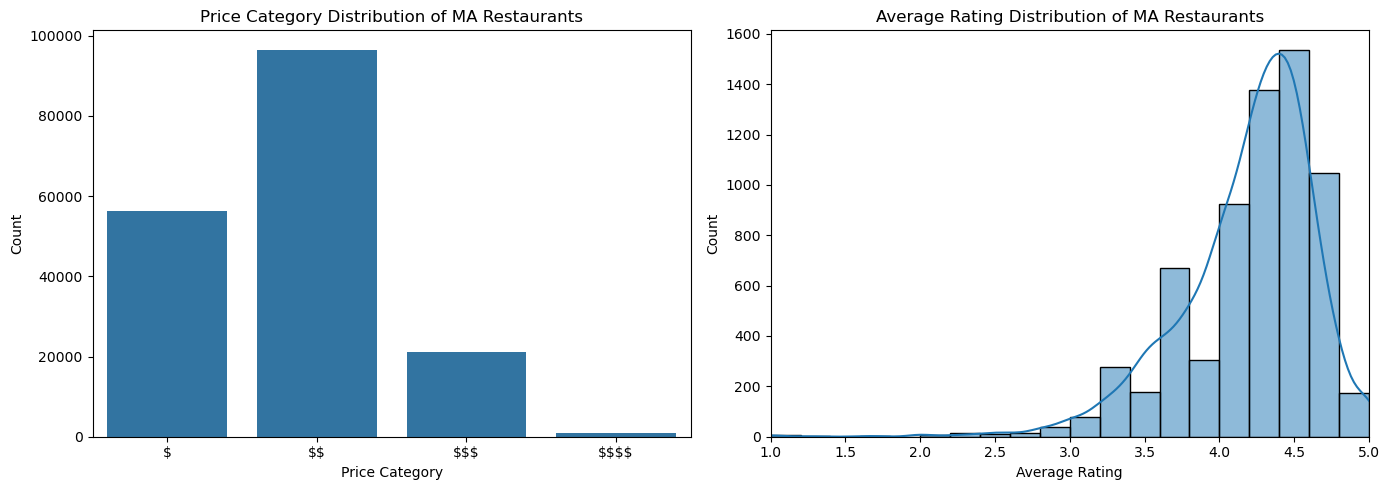

In [12]:
valid_prices = df_cleaned['price'].astype(str)
price_lengths = valid_prices.apply(len)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot 1: Price Category Distribution
sns.countplot(x=price_lengths, ax=axes[0])
axes[0].set_title('Price Category Distribution of MA Restaurants')
xticklabels = [r'{}'.format('\$' * p) for p in sorted(price_lengths.unique())]
axes[0].set_xticks(range(len(xticklabels)))
axes[0].set_xticklabels(xticklabels)
axes[0].set_xlabel('Price Category')
axes[0].set_ylabel('Count')

# Plot 2: Average Rating of Restaurants
sns.histplot(restaurant_ma['avg_rating'], ax=axes[1], bins=20, kde=True)
axes[1].set_title('Average Rating Distribution of MA Restaurants')
axes[1].set_xlabel('Average Rating')
axes[1].set_xlim([1,5])
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

The first chart shows the distribution of restaurants across different price categories, indicating increasing levels of expense, from budget-friendly to high-end dining experiences.
* \$\$ category indicates a moderate price level, and it's clear from the chart that this category encompasses the majority of restaurants. This suggests that **most restaurants in Massachusetts are priced at a mid-range or budget-friendly level**, accessible to a broad segment of the population.

The second chart shows the distribution of average ratings for restaurants, which is crucial for understanding consumer satisfaction:
* The ratings are mostly concentrated around the 4.0 to 4.5 range, indicating that the **majority of restaurants are well-regarded** by customers.
* There's a notable decrease in frequency as ratings approach the lower end of the scale, with very few restaurants rated below 3.0. This pattern suggests that poorly rated restaurants are relatively rare, OR possibly that consumers prefer not to rate rather than leave a low rating.
* The skew towards higher ratings may also reflect a **bias in consumer reporting**, where only motivated, satisfied customers choose to leave reviews.


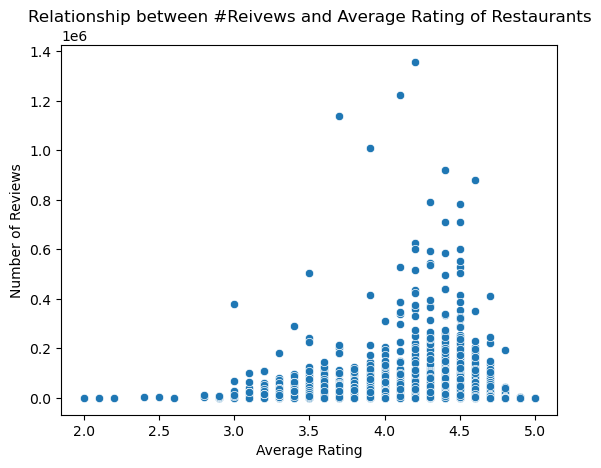

In [13]:
num_reviews_restaurant = df_cleaned.groupby("gmap_id")["num_of_reviews"].sum()
avg_ratings_restaurant = df_cleaned.groupby("gmap_id")["avg_rating"].mean()
sns.scatterplot(x = avg_ratings_restaurant, y = num_reviews_restaurant);
plt.title('Relationship between #Reivews and Average Rating of Restaurants')
plt.xlabel('Average Rating')
plt.ylabel('Number of Reviews')
plt.show()

Key observations from the plot include
1. **Higher Density at Higher Ratings:** The graph shows a clear concentration of data points towards higher ratings, particularly around the 4.0 to 4.5 range. 
2. **Sparse Data at Lower Ratings:** There are fewer restaurants with lower average ratings (2.0 to 3.5), and these establishments also tend to have fewer reviews. This could indicate that restaurants with lower customer satisfaction either receive less feedback overall or are less frequently visited.

This graph provides evidence supporting a potential bias in consumer reporting, as previously indicated by the previous plot of distribution of average ratings


# 4. Modeling Approach

## 4.1 Baseline Model

In [14]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [15]:
df_cleaned = pd.read_csv("data/df_cleaned.csv")[
        ['user_id', 'name_y', 'rating', 'text', 'gmap_id', 'latitude', 'longitude', 'num_of_reviews', 'price', 'avg_rating']
    ]

In [16]:
print(df_cleaned.isnull().any())
print()
print(f"Percentage of missing review text: {df_cleaned['text'].isna().sum()/len(df_cleaned)*100:.2f}%")
print(f"Percentage of reviews with missing values in 'price' column: {df_cleaned['price'].isna().sum()/len(df_cleaned)*100:.2f}%")

user_id           False
name_y            False
rating            False
text              False
gmap_id           False
latitude          False
longitude         False
num_of_reviews    False
price              True
avg_rating        False
dtype: bool

Percentage of missing review text: 0.00%
Percentage of reviews with missing values in 'price' column: 8.15%


In [17]:
df_cleaned.dropna(inplace=True)
# df_cleaned.price.value_counts()
df_cleaned = df_cleaned[~df_cleaned['price'].isin(['₩₩', '₩', '₩₩₩₩', '₩₩₩'])]
df_cleaned.price.value_counts()


price
$$      94764
$       55767
$$$      6558
$$$$      819
Name: count, dtype: int64

In [18]:
df_cleaned.dropna(inplace=True)
one_hot = pd.get_dummies(df_cleaned['price'])
df_cleaned = pd.concat([df_cleaned, one_hot], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop(['rating','text','name_y','price','user_id','gmap_id'], axis=1), 
                                                    df_cleaned[['rating']], 
                                                    test_size=0.3, random_state=209)

In [19]:
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
pred1 = model1.predict(X_test)
# rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
mse = mean_squared_error(y_test, pred1)  
rmse = np.sqrt(mse) 
print(f'content-based rmse = {rmse:.4f}')

content-based rmse = 1.0437


In [21]:
feature_importance = pd.DataFrame(model1.feature_importances_, index=X_train.columns, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

                Importance
avg_rating        0.799987
$$$               0.035774
$$$$              0.035168
$                 0.027545
longitude         0.026476
$$                0.026437
num_of_reviews    0.025942
latitude          0.022671


## 4.2 Incorperating Review Embeddings (Text-based)

In [22]:
import importlib
import utility
importlib.reload(utility)

import numpy as np
import pandas as pd
from utility import get_similar_users_avg_rating, merge_df

RERUN_EMBED = False

In [23]:
user_df = pd.read_csv('data/user_concat_text_10_20.csv', sep=';')

In [24]:
df_filtered = pd.read_csv("data/english_reviews.csv")
df_cleaned = pd.read_csv("data/df_cleaned.csv")
df_cleaned['user_id'] = df_cleaned['user_id'].astype(str)

### 4.2.1 Word2Vec

### 4.2.2 Bag of Words

### 4.2.3 Latent Dirichlet Allocation (LDA)

### 4.2.4 Large Language Model (BERT)

In [25]:
if RERUN_EMBED:
    import torch
    from transformers import BertModel, BertTokenizer

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def generate_embedding(input_text):
        # Tokenize input text
        input_ids = tokenizer.encode_plus(input_text, 
                                        add_special_tokens=True, 
                                        return_tensors="pt", 
                                        truncation=True,
                                        max_length=512,
                                        padding='max_length')  # Adjust max_length
        input_ids = input_ids.to(device)
        with torch.no_grad():
            model.to(device)
            outputs = model(**input_ids)  # Pass the tokenized inputs as keyword arguments
            embeddings =outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
        return embeddings
    
    train_df['bert_embedding'] = train_df['text'].apply(generate_embedding)
    train_df['bert_embedding'] = train_df['bert_embedding'].apply(lambda x: x.reshape(-1,))
    np.save('data/train_bert_embeddings.npy', np.array(train_df['bert_embedding'].to_list()))

    test_df['bert_embedding'] = test_df['text'].apply(generate_embedding)
    test_df['bert_embedding'] = test_df['bert_embedding'].apply(lambda x: x.reshape(-1,))
    np.save('data1/test_bert_embeddings.npy', np.array(test_df['bert_embedding'].to_list()))

In [26]:
if RERUN_EMBED:
    train_df_cleaned['bert_rating'] = train_df_cleaned.progress_apply(lambda row: get_similar_users_avg_rating(
            train_df, df_filtered, row['user_id'], row['gmap_id'],
            'data/train_bert_embeddings.npy'
        ), axis=1)
    # Replace None with pd.nan in 'bert_rating' column
    train_df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)
    train_df_cleaned.to_csv("data/train_df_cleaned.csv", index=False)

    test_df_cleaned['bert_rating'] = test_df_cleaned.progress_apply(lambda row: get_similar_users_avg_rating(
            test_df, df_filtered, row['user_id'], row['gmap_id'],
            'data/test_bert_embeddings.npy'
        ), axis=1)
    test_df_cleaned['bert_rating'].replace({None: np.nan}, inplace=True)
    test_df_cleaned.to_csv("data/test_df_cleaned.csv", index=False)

# 5. Results